In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def beam_generator_G2(
    bunch1_charge_pC,
    bunch1_sigma_um,
    bunch2_charge_pC,
    bunch2_sigma_um,
    distance_um,
    windowsize=1024,
    resolution_um=0.1
):
    """
    Generate a 1D beam profile consisting of two separated Gaussian bunches.

    Parameters:
        bunch1_charge_pC  : charge of bunch 1   (pC)
        bunch1_sigma_um   : sigma of bunch 1    (um)
        bunch2_charge_pC  : charge of bunch 2   (pC)
        bunch2_sigma_um   : sigma of bunch 2    (um)
        distance_um       : separation between two bunch centers (um)
        windowsize        : length of output array
        resolution_um     : spatial resolution of each sample

    Returns:
        x_um: spatial axis (um)
        y: beam profile array of length `windowsize`
    """

    # x-axis
    x_um = np.arange(windowsize) * resolution_um

    # choose center positions
    center1 = windowsize * resolution_um / 2 - distance_um / 2
    center2 = windowsize * resolution_um / 2 + distance_um / 2

    # two Gaussian bunches
    g1 = bunch1_charge_pC * np.exp(-(x_um - center1) ** 2 / (2 * bunch1_sigma_um ** 2))
    g2 = bunch2_charge_pC * np.exp(-(x_um - center2) ** 2 / (2 * bunch2_sigma_um ** 2))

    y = g1 + g2
    return x_um, y


In [8]:
def generate_G2_dataset(
    n,
    range_charge,
    range_sigma,
    range_distance,
    save_dir,
    windowsize=1024,
    resolution=0.1
):
    """
    Generate n random G2 beam arrays and save as CSV.
    CSV includes two columns: x_um, Intensity
    """

    os.makedirs(save_dir, exist_ok=True)

    for i in range(n):

        # Random parameters
        b1_charge = np.random.uniform(*range_charge)
        b2_charge = np.random.uniform(*range_charge)

        b1_sigma  = np.random.uniform(*range_sigma)
        b2_sigma  = np.random.uniform(*range_sigma)

        distance  = np.random.uniform(*range_distance)

        # Generate waveform
        x_um, y = beam_generator_G2(
            b1_charge, b1_sigma,
            b2_charge, b2_sigma,
            distance,
            windowsize,
            resolution
        )

        # File name with real values
        filename = (
            f"G2_{i+1}_"
            f"Q1_{b1_charge:.2f}_s1_{b1_sigma:.2f}_"
            f"Q2_{b2_charge:.2f}_s2_{b2_sigma:.2f}_"
            f"d_{distance:.2f}.csv"
        )
        filepath = os.path.join(save_dir, filename)

        # Save as CSV containing both x and y
        df = pd.DataFrame({
            "x_um": x_um,
            "Intensity": y
        })
        df.to_csv(filepath, index=False)

        print(f"[Saved] {filepath}")

    print("\nDataset generation completed!")

def generate_G2R_dataset(
    n,
    range_charge,
    range_sigma,
    range_distance,
    ratio_range,          # (r_min, r_max) 
    save_dir,
    windowsize=1024,
    resolution=0.1
):
    """
    Generate n random G2 beam arrays and save as CSV.
    - b1 >= b2 by construction
    - ratio = b1 / b2 is log-uniform for physical correctness
    """

    os.makedirs(save_dir, exist_ok=True)
    r_min, r_max = ratio_range

    for i in range(n):

        # -----------------------------
        # 1. Base amplitude (big peak)
        # -----------------------------
        b1_charge = np.random.uniform(*range_charge)

        # -----------------------------
        # 2. log-uniform ratio r >= 1
        # -----------------------------
        u = np.random.uniform(np.log(r_min), np.log(r_max))
        ratio = np.exp(u)    # log-uniform ratio

        # -----------------------------
        # 3. Compute second peak (small)
        # -----------------------------
        b2_charge = b1_charge / ratio   # b1 >= b2

        # -----------------------------
        # 4. Sigmas (width)
        # -----------------------------
        b1_sigma = np.random.uniform(*range_sigma)
        b2_sigma = np.random.uniform(*range_sigma)

        # -----------------------------
        # 5. Distance
        # -----------------------------
        distance = np.random.uniform(*range_distance)

        # -----------------------------
        # 6. Generate waveform
        # -----------------------------
        x_um, y = beam_generator_G2(
            b1_charge, b1_sigma,
            b2_charge, b2_sigma,
            distance,
            windowsize,
            resolution
        )

        # -----------------------------
        # 7. Save CSV
        # -----------------------------
        filename = (
            f"G2R_{i+1}_"
            f"Q1_{b1_charge:.3f}_s1_{b1_sigma:.3f}_"
            f"Q2_{b2_charge:.3f}_s2_{b2_sigma:.3f}_"
            f"ratio_{ratio:.3f}_d_{distance:.3f}.csv"
        )
        filepath = os.path.join(save_dir, filename)

        df = pd.DataFrame({
            "x_um": x_um,
            "Intensity": y
        })
        df.to_csv(filepath, index=False)

        print(f"[Saved] {filepath}")

    print("\nDataset generation completed with log-uniform ratio!")


def generate_G2RR_dataset(
    n,
    range_charge,
    range_sigma,
    range_distance,
    ratio_range_charge,          # (r_min, r_max) 
    ratio_range_sigma,
    save_dir,
    windowsize=1024,
    resolution=0.1
):
    """
    Generate n random G2 beam arrays and save as CSV.
    - b1 >= b2 by construction
    - ratio = b1 / b2 is log-uniform for physical correctness
    """

    os.makedirs(save_dir, exist_ok=True)
    rc_min, rc_max = ratio_range_charge
    rs_min, rs_max = ratio_range_sigma

    for i in range(n):


        b1_charge = np.random.uniform(*range_charge)

        u = np.random.uniform(np.log(rc_min), np.log(rc_max))
        ratio_c = np.exp(u)    # log-uniform ratio
        b2_charge = b1_charge / ratio_c   # b1 >= b2


        b1_sigma = np.random.uniform(*range_sigma)

        v = np.random.uniform(np.log(rs_min), np.log(rs_max))
        ratio_s = np.exp(v)
        b2_sigma = b1_sigma / ratio_s


        distance = np.random.uniform(*range_distance)


        x_um, y = beam_generator_G2(
            b1_charge, b1_sigma,
            b2_charge, b2_sigma,
            distance,
            windowsize,
            resolution
        )

        filename = (
            f"G2R_{i+1}_"
            f"Q1_{b1_charge:.3f}_s1_{b1_sigma:.3f}_"
            f"Q2_{b2_charge:.3f}_s2_{b2_sigma:.3f}_"
            f"ratioc_{ratio_c:.3f}_ratios_{ratio_s:.3f}.csv"
            f"d_{distance:.2f}.csv"
        )
        filepath = os.path.join(save_dir, filename)

        df = pd.DataFrame({
            "x_um": x_um,
            "Intensity": y
        })
        df.to_csv(filepath, index=False)

        print(f"[Saved] {filepath}")

    print("\nDataset generation completed with log-uniform ratio!")


def generate_G2RP_dataset(
    n,
    range_charge,
    range_sigma_1,
    range_sigma_2,
    range_distance,
    ratio_range_charge,          # (r_min, r_max) 
    save_dir,
    windowsize=1024,
    resolution=0.1
):
    """
    Generate n random G2 beam arrays and save as CSV.
    - b1 >= b2 by construction
    - ratio = b1 / b2 is log-uniform for physical correctness
    """

    os.makedirs(save_dir, exist_ok=True)
    rc_min, rc_max = ratio_range_charge

    for i in range(n):


        b1_charge = np.random.uniform(*range_charge)

        u = np.random.uniform(np.log(rc_min), np.log(rc_max))
        ratio_c = np.exp(u)    # log-uniform ratio
        b2_charge = b1_charge / ratio_c   # b1 >= b2


        b1_sigma = np.random.uniform(*range_sigma_1)
        b2_sigma = np.random.uniform(*range_sigma_2)


        distance = np.random.uniform(*range_distance)


        x_um, y = beam_generator_G2(
            b1_charge, b1_sigma,
            b2_charge, b2_sigma,
            distance,
            windowsize,
            resolution
        )

        filename = (
            f"G2RP_{i+1}_"
            f"Q1_{b1_charge:.3f}_s1_{b1_sigma:.3f}_"
            f"Q2_{b2_charge:.3f}_s2_{b2_sigma:.3f}_"
            f"ratioc_{ratio_c:.3f}_d_{distance:.2f}.csv"
        )
        filepath = os.path.join(save_dir, filename)

        df = pd.DataFrame({
            "x_um": x_um,
            "Intensity": y
        })
        df.to_csv(filepath, index=False)

        print(f"[Saved] {filepath}")

    print("\nDataset generation completed with log-uniform ratio!")


import os
import numpy as np
import torch
import pandas as pd

def generate_G2RP_pt_dataset(
    n,
    range_charge,
    range_sigma_1,
    range_sigma_2,
    range_distance,
    ratio_range_charge,          # (r_min, r_max) 
    save_dir,
    windowsize=1024,
    resolution=0.1
):
    """
    Generate n random G2 beam arrays and save each sample as a .pt file.
    - b1 >= b2 by construction
    - ratio = b1 / b2 is log-uniform
    - values rounded to 5 decimals
    """

    os.makedirs(save_dir, exist_ok=True)
    rc_min, rc_max = ratio_range_charge

    for i in range(n):

        # --- 1) Random parameters ---
        b1_charge = np.random.uniform(*range_charge)

        u = np.random.uniform(np.log(rc_min), np.log(rc_max))
        ratio_c = np.exp(u)                  # log-uniform ratio
        b2_charge = b1_charge / ratio_c      # ensure b1 >= b2

        b1_sigma = np.random.uniform(*range_sigma_1)
        b2_sigma = np.random.uniform(*range_sigma_2)

        distance = np.random.uniform(*range_distance)

        # --- 2) Generate beam ---
        x_um, y = beam_generator_G2(
            b1_charge, b1_sigma,
            b2_charge, b2_sigma,
            distance,
            windowsize,
            resolution
        )

        # --- 3) 保留 5 位小数 ---
        x_um = np.round(x_um, 5)
        y    = np.round(y,    5)

        # --- 4) 转为 tensor ---
        x_tensor = torch.tensor(x_um, dtype=torch.float32)
        y_tensor = torch.tensor(y,    dtype=torch.float32)

        # --- 5) 保存为 .pt ---
        sample = {
            "x_um": x_tensor,
            "Intensity": y_tensor,
            "b1_charge": float(np.round(b1_charge, 5)),
            "b2_charge": float(np.round(b2_charge, 5)),
            "b1_sigma":  float(np.round(b1_sigma, 5)),
            "b2_sigma":  float(np.round(b2_sigma, 5)),
            "ratio_c":   float(np.round(ratio_c, 5)),
            "distance":  float(np.round(distance, 5)),
        }

        filename = (
            f"G2RP_pt_{i+1}_"
            f"Q1_{sample['b1_charge']}_s1_{sample['b1_sigma']}_"
            f"Q2_{sample['b2_charge']}_s2_{sample['b2_sigma']}_"
            f"r_{sample['ratio_c']}_d_{sample['distance']}.pt"
        )

        filepath = os.path.join(save_dir, filename)
        torch.save(sample, filepath)

        print(f"[Saved] {filepath}")

    print("\nDataset (.pt) generation completed with 5-decimal precision!")




In [10]:
def generate_G2RPL_pt_dataset(
    n,
    range_charge,
    range_sigma_1,
    range_sigma_2,
    range_distance,
    ratio_range_charge,          # (r_min, r_max) 
    save_dir,
    windowsize=1024,
    resolution=0.1
):
    """
    Generate n random G2 beam arrays and save each sample as a .pt file.
    - b1 >= b2 by construction
    - ratio = b1 / b2 is log-uniform
    - values rounded to 5 decimals
    """

    os.makedirs(save_dir, exist_ok=True)
    rc_min, rc_max = ratio_range_charge
    s1_min, s1_max = range_sigma_1
    s2_min, s2_max = range_sigma_2


    for i in range(n):

        # --- 1) Random parameters ---
        b1_charge = np.random.uniform(*range_charge)

        u = np.random.uniform(np.log(rc_min), np.log(rc_max))
        ratio_c = np.exp(u)                  # log-uniform ratio
        b2_charge = b1_charge / ratio_c      # ensure b1 >= b2

        v = np.random.uniform(np.log(s1_min), np.log(s1_max))
        b1_sigma = np.exp(v)
        w = np.random.uniform(np.log(s2_min), np.log(s2_max))
        b2_sigma = np.exp(w)

        distance = np.random.uniform(*range_distance)

        # --- 2) Generate beam ---
        x_um, y = beam_generator_G2(
            b1_charge, b1_sigma,
            b2_charge, b2_sigma,
            distance,
            windowsize,
            resolution
        )

        # --- 3) 保留 5 位小数 ---
        x_um = np.round(x_um, 5)
        y    = np.round(y,    5)

        # --- 4) 转为 tensor ---
        x_tensor = torch.tensor(x_um, dtype=torch.float32)
        y_tensor = torch.tensor(y,    dtype=torch.float32)

        # --- 5) 保存为 .pt ---
        sample = {
            "x_um": x_tensor,
            "Intensity": y_tensor,
            "b1_charge": float(np.round(b1_charge, 5)),
            "b2_charge": float(np.round(b2_charge, 5)),
            "b1_sigma":  float(np.round(b1_sigma, 5)),
            "b2_sigma":  float(np.round(b2_sigma, 5)),
            "ratio_c":   float(np.round(ratio_c, 5)),
            "distance":  float(np.round(distance, 5)),
        }

        filename = (
            f"G2RP_pt_{i+1}_"
            f"Q1_{sample['b1_charge']}_s1_{sample['b1_sigma']}_"
            f"Q2_{sample['b2_charge']}_s2_{sample['b2_sigma']}_"
            f"r_{sample['ratio_c']}_d_{sample['distance']}.pt"
        )

        filepath = os.path.join(save_dir, filename)
        torch.save(sample, filepath)

        # print(f"[Saved] {filepath}")

    print("\nDataset (.pt) generation completed with log-uniform!")

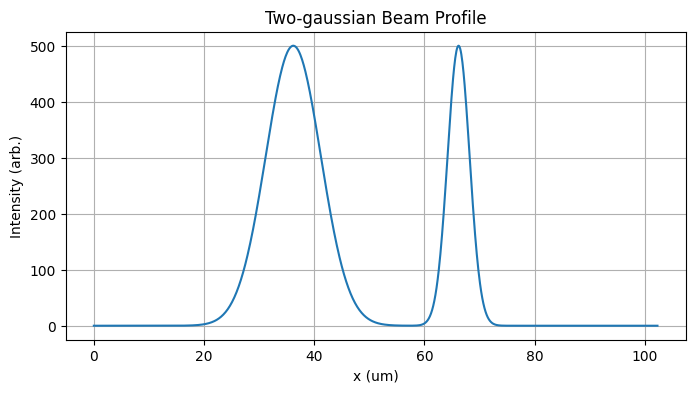

In [ ]:
# G2 example
bunch1_charge = 500.0    # pC
bunch1_sigma  = 5.0    # um

bunch2_charge = 500.0    # pC
bunch2_sigma  = 2.0    # um

distance      = 30.0   # um

windowsize   = 1024
resolution   = 0.1     # um
# =================================


# 生成数据
x_um, y = beam_generator_G2(
    bunch1_charge,
    bunch1_sigma,
    bunch2_charge,
    bunch2_sigma,
    distance,
    windowsize,
    resolution
)


plt.figure(figsize=(8,4))
plt.plot(x_um, y)
plt.xlabel("x (um)")
plt.ylabel("Intensity (arb.)")
plt.title("Two-gaussian Beam Profile")
plt.grid(True)
plt.show()

# y


In [11]:
# ==== parameters ====
range_charge   = (100, 800)   # pC
range_sigma_1  = (2, 5)        # um
range_sigma_2  = (1, 3)        # um
range_distance = (20, 40)      # um
ratio_range_charge = (0.5, 3)
# ratio_range_sigma = (0.3, 3)
n = 100000
save_dir = "./generated_beam_profile/G2RPL_pt_100_800_2_5_1_3_20_40_05_3_100000" 
# =================================

generate_G2RPL_pt_dataset(
    n=n,
    range_charge=range_charge,
    range_sigma_1=range_sigma_1,
    range_sigma_2=range_sigma_2,
    range_distance=range_distance,
    ratio_range_charge=ratio_range_charge,
    save_dir=save_dir,
    windowsize=256,
    resolution=0.4
)



Dataset (.pt) generation completed with log-uniform!
